In [13]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore')

In [14]:
with zipfile.ZipFile("credit-risk-dataset.zip") as myzip:
    data = myzip.open("loan/loan.csv")

df = pd.read_csv(data)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Check NULL values in the data

In [15]:
df.isnull().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
all_util            866007
total_rev_hi_lim     70276
inq_fi              866007
total_cu_tl         866007
inq_last_12m        866007
Length: 74, dtype: int64

### Take a sample of whole data to create the Model

In [16]:
df_sample = df.sample(frac=0.15)
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133107 entries, 795758 to 676989
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           133107 non-null  int64  
 1   member_id                    133107 non-null  int64  
 2   loan_amnt                    133107 non-null  float64
 3   funded_amnt                  133107 non-null  float64
 4   funded_amnt_inv              133107 non-null  float64
 5   term                         133107 non-null  object 
 6   int_rate                     133107 non-null  float64
 7   installment                  133107 non-null  float64
 8   grade                        133107 non-null  object 
 9   sub_grade                    133107 non-null  object 
 10  emp_title                    125311 non-null  object 
 11  emp_length                   126367 non-null  object 
 12  home_ownership               133107 non-null  object 
 13 

In [52]:
df_sample.head(100).to_csv('loan_sample.csv', index=False)

In [17]:
# Display all the columns in the Data Set
df_sample.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [18]:
# Create a Columns list and include only columns needed to creating the model
columns = ['loan_amnt', 'int_rate', 'term', 'dti', 'annual_inc', 'delinq_2yrs', 'open_acc',
           'grade', 'home_ownership', 'collections_12_mths_ex_med', 'revol_bal', 'total_acc',
           'loan_status']

df_clean = df_sample[columns]
df_clean.head()

,loan_amnt,int_rate,term,dti,annual_inc,delinq_2yrs,open_acc,grade,home_ownership,collections_12_mths_ex_med,revol_bal,total_acc,loan_status
795758,25000.0,10.99,60 months,29.15,87937.0,2.0,16.0,B,MORTGAGE,0.0,14164.0,34.0,Current
261271,4100.0,12.99,36 months,26.94,49593.0,0.0,11.0,C,MORTGAGE,0.0,31605.0,35.0,Current
91402,24000.0,12.35,60 months,8.69,110000.0,1.0,13.0,B,MORTGAGE,0.0,27001.0,28.0,Fully Paid
610157,21000.0,6.89,36 months,6.22,150000.0,0.0,7.0,A,MORTGAGE,0.0,7937.0,15.0,Current
265447,14625.0,17.57,60 months,15.56,65000.0,0.0,11.0,D,MORTGAGE,0.0,1196.0,29.0,Charged Off


In [19]:
df_clean.isnull().sum()

loan_amnt                      0
int_rate                       0
term                           0
dti                            0
annual_inc                     2
delinq_2yrs                    5
open_acc                       5
grade                          0
home_ownership                 0
collections_12_mths_ex_med    26
revol_bal                      0
total_acc                      5
loan_status                    0
dtype: int64

In [20]:
# Create a function to convert Loan Status values into understandable values
def categorize_loan_status(status):
    if status in ['Fully Paid', 'In Grace Period', 'Issued']:
        return 'Normal'
    elif status in ['Late (16-30 days)', 'Late (31-120 days)']:
        return 'Delinquent'
    elif status in ['Charged Off', 'Default']:
        return 'Default'
    elif 'Does not meet the credit policy' in status:
        return 'Not Compliant'
    elif 'Current' in status:
        return 'Current'
    else:
        return 'Unknown'
    
df_clean['loan_status'] = df_clean['loan_status'].apply(categorize_loan_status)

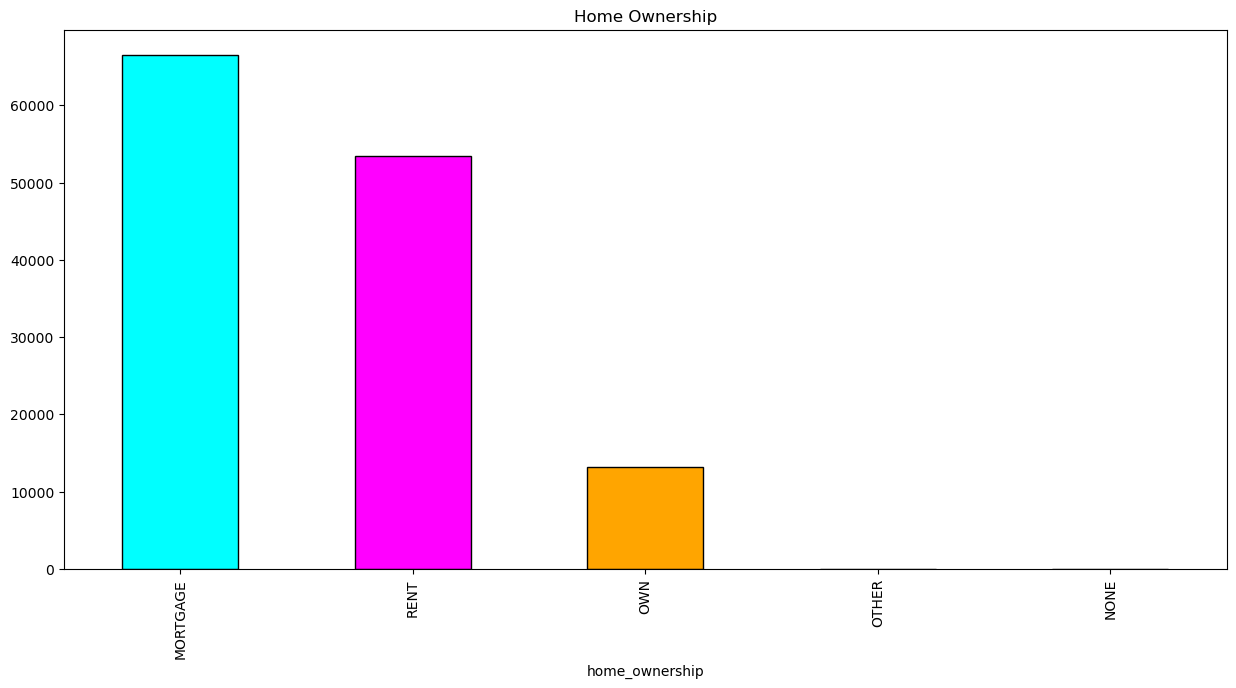

In [21]:
# Plot Count vs Home Ownership
# Label 0 = Mortgage, 1 = Misc, 2 = Other, 3 = Own, 4 = Rent
colors = ['cyan', 'magenta', 'orange', 'purple', 'red']
df_clean['home_ownership'].value_counts().plot(kind='bar', 
        title='Home Ownership', color=colors, edgecolor='black', figsize=(15,7))

plt.show()

<Axes: xlabel='int_rate', ylabel='grade'>

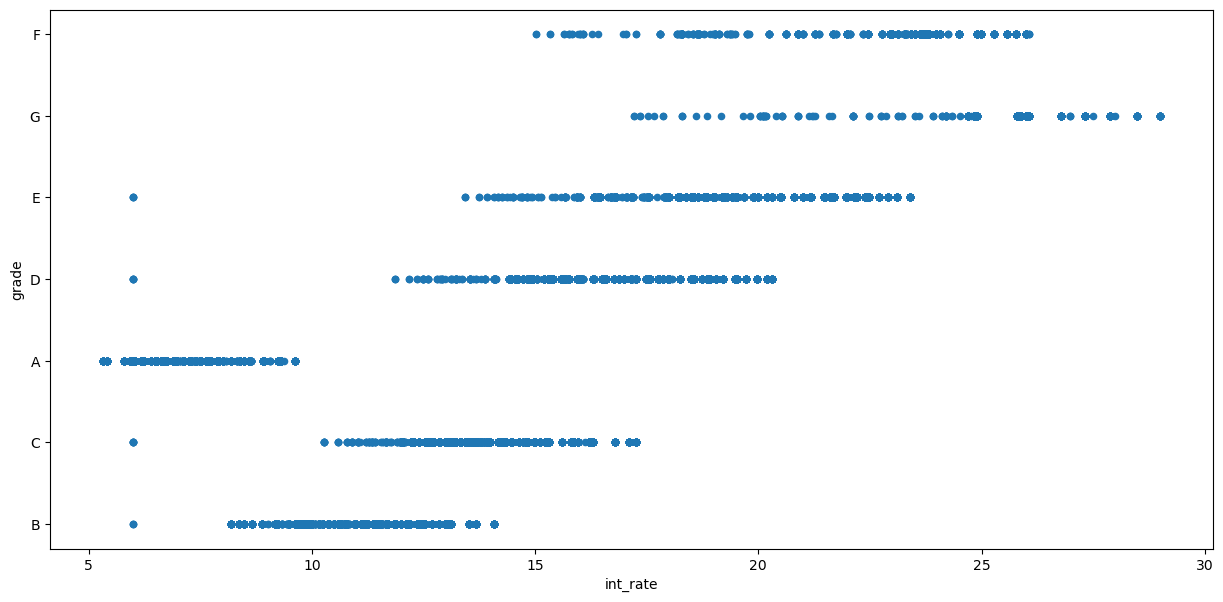

In [22]:
# Plot df_data_clean['int_rate'] vs grade
df_clean.plot.scatter(x='int_rate', y='grade', figsize=(15,7))

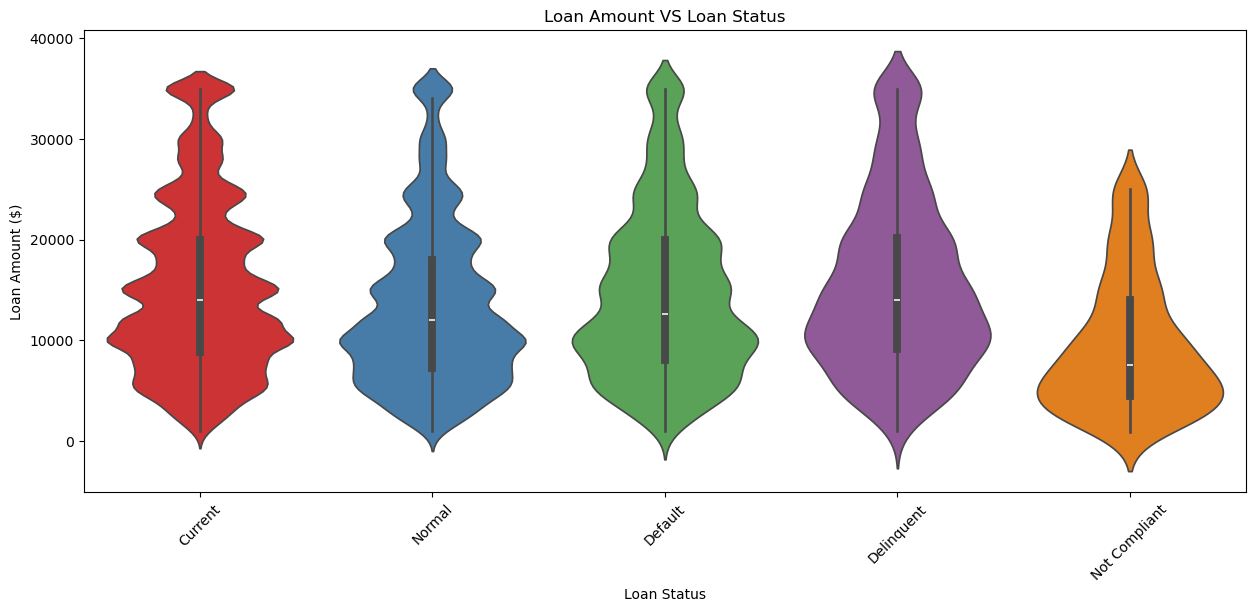

In [23]:
# Graph between Loan Amount and Loan Status
plt.figure(figsize=(15, 6))
sns.violinplot(x='loan_status', y='loan_amnt', palette='Set1' ,data=df_clean)
plt.title('Loan Amount VS Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Loan Amount ($)')
plt.xticks(rotation=45)
plt.show()

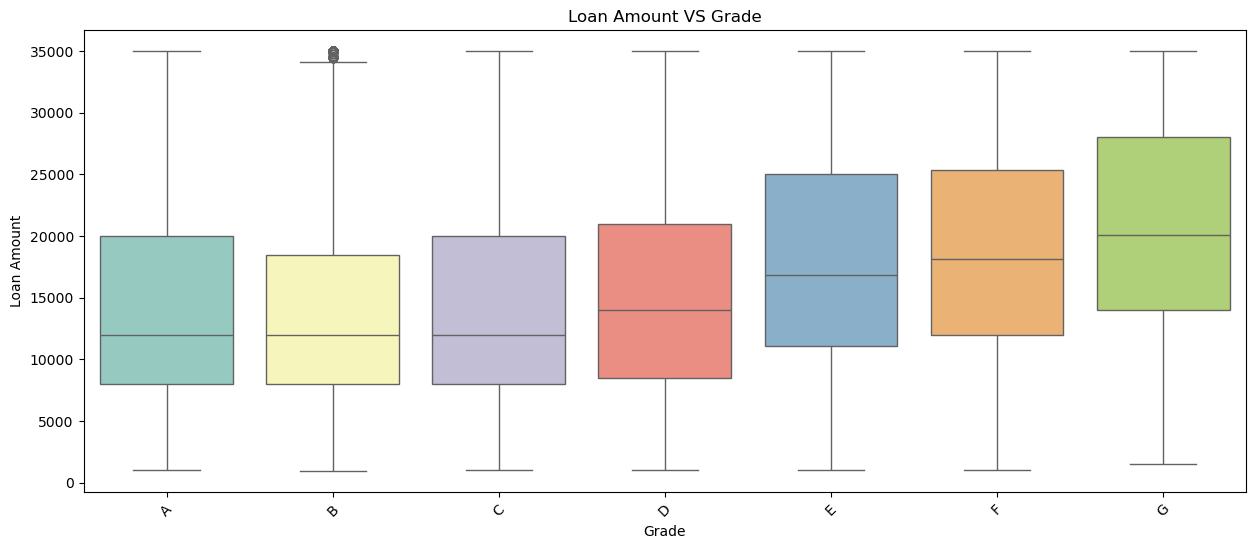

In [24]:
# Graph between Loan Amount and Grade
order_grade  = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

plt.figure(figsize=(15, 6))
sns.boxplot(x='grade', y='loan_amnt', data=df_clean, palette='Set3', order=order_grade)
plt.title('Loan Amount VS Grade')
plt.xlabel('Grade')
plt.ylabel('Loan Amount')
plt.xticks(rotation=45)
plt.show()

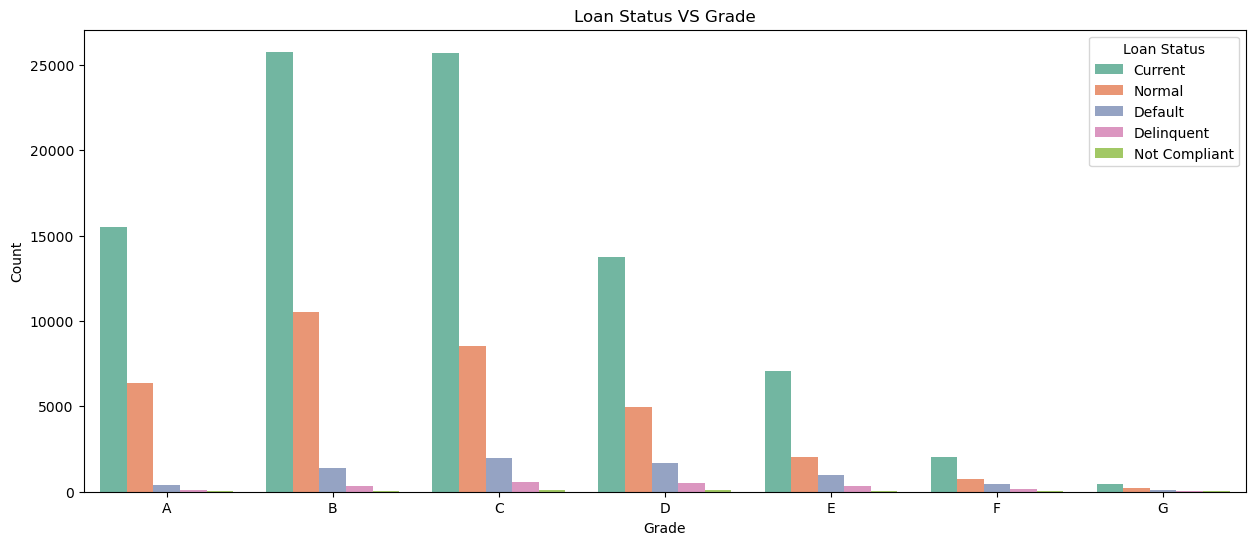

In [25]:
# Graph between Loan status and Grade
plt.figure(figsize=(15, 6))
sns.countplot(x='grade', hue='loan_status', data=df_clean, palette='Set2', order= order_grade)
plt.title('Loan Status VS Grade')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.legend(title='Loan Status', loc='upper right')
plt.show()

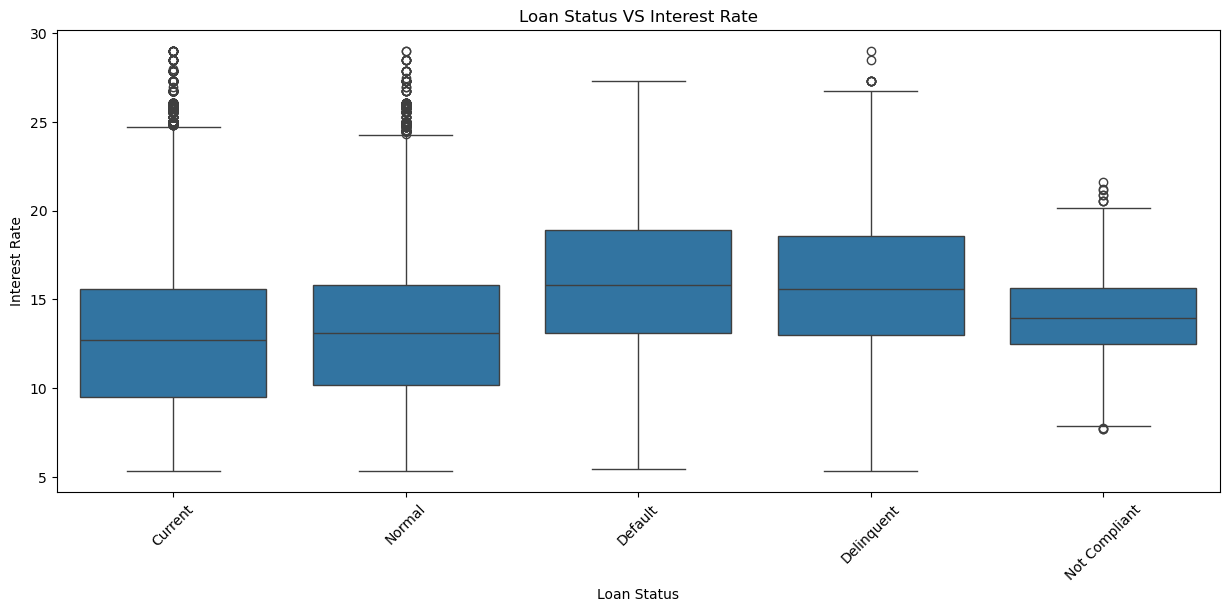

In [26]:
# Graph between Loan Status and Interest Rate
plt.figure(figsize=(15, 6))
sns.boxplot(x='loan_status', y = 'int_rate', data=df_clean)
plt.title('Loan Status VS Interest Rate')
plt.xlabel('Loan Status')
plt.ylabel('Interest Rate')
plt.xticks(rotation=45)
plt.show()

## *Loan Status VS Home Ownership*

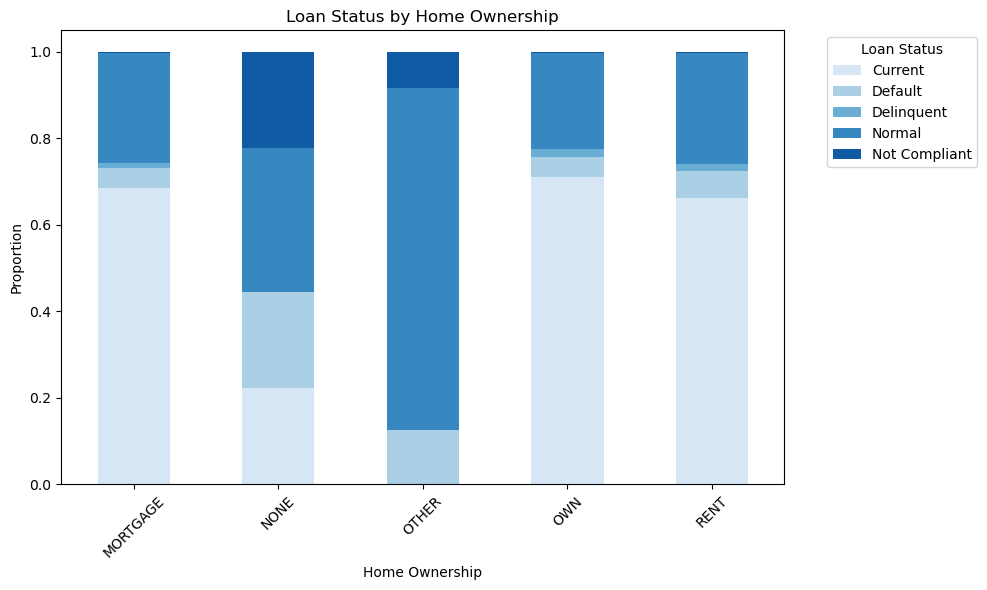

In [27]:
cross_tab = pd.crosstab(df_clean['home_ownership'], df_clean['loan_status'])

cross_tab_percentage = cross_tab.div(cross_tab.sum(1), axis=0)

colors = sns.color_palette("Blues", n_colors=cross_tab_percentage.shape[1])
cross_tab_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

plt.title('Loan Status by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Proportion')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## *Converting Categorical Data in to Numerical Data (Multi-Class Classification)*

In [28]:
from sklearn.preprocessing import LabelEncoder

def LabelEncoder1(text):
    if text == 'A':
        return 1
    elif text == 'B':
        return 2
    elif text == 'C':
        return 3
    elif text == 'D':
        return 4
    elif text == 'E':
        return 5
    elif text == 'F':
        return 6
    elif text == 'G':
        return 7

def LabelEncoder2(text):
    if text == ' 36 months':
        return 1
    else:
        return 2
    
def LabelEncoder3(text):
    if text == "RENT":
        return 1
    elif text == "MORTGAGE":
        return 2
    elif text == "OWN":
        return 3
    else:
        return 0
    
df_clean['grade'] = df_clean['grade'].apply(LabelEncoder1)
df_clean['term'] = df_clean['term'].apply(LabelEncoder2)
df_clean['home_ownership'] = df_clean['home_ownership'].apply(LabelEncoder3)



In [29]:
df_clean[['grade', 'term', 'home_ownership']].head()

,grade,term,home_ownership
795758,2,2,2
261271,3,1,2
91402,2,2,2
610157,1,1,2
265447,4,2,2


In [30]:
df_clean['loan_status'].value_counts().reset_index()

,loan_status,count
0,Current,90270
1,Normal,33362
2,Default,6965
3,Delinquent,2088
4,Not Compliant,422


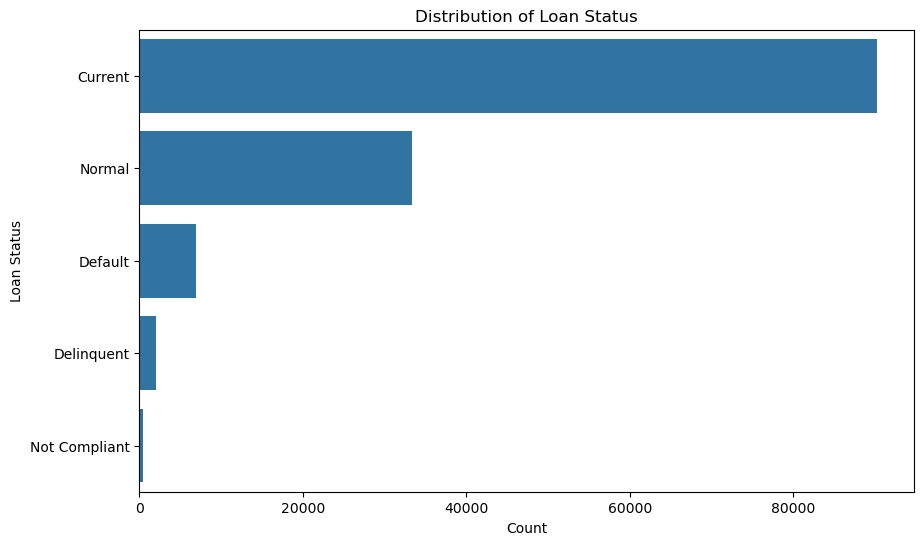

In [31]:
# Graph shows Distribution of Loan status 
loan_status_counts = df_clean['loan_status'].value_counts().reset_index()
loan_status_counts.columns = ['Loan Status', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(y='Loan Status', x='Count', data=loan_status_counts)

plt.title('Distribution of Loan Status')
plt.ylabel('Loan Status')
plt.xlabel('Count')

plt.show()

Encoding Y to numeric values

In [32]:
y = df_clean['loan_status']

def y_encoded(text):
    if text == "Normal":
        return 0
    elif text in ['Default', 'Delinquent', 'Not Compliant']:
        return 1
    else:
        return 2
    
y_encode =  y.apply(y_encoded)

In [33]:
y_encode.value_counts().reset_index()

,loan_status,count
0,2,90270
1,0,33362
2,1,9475


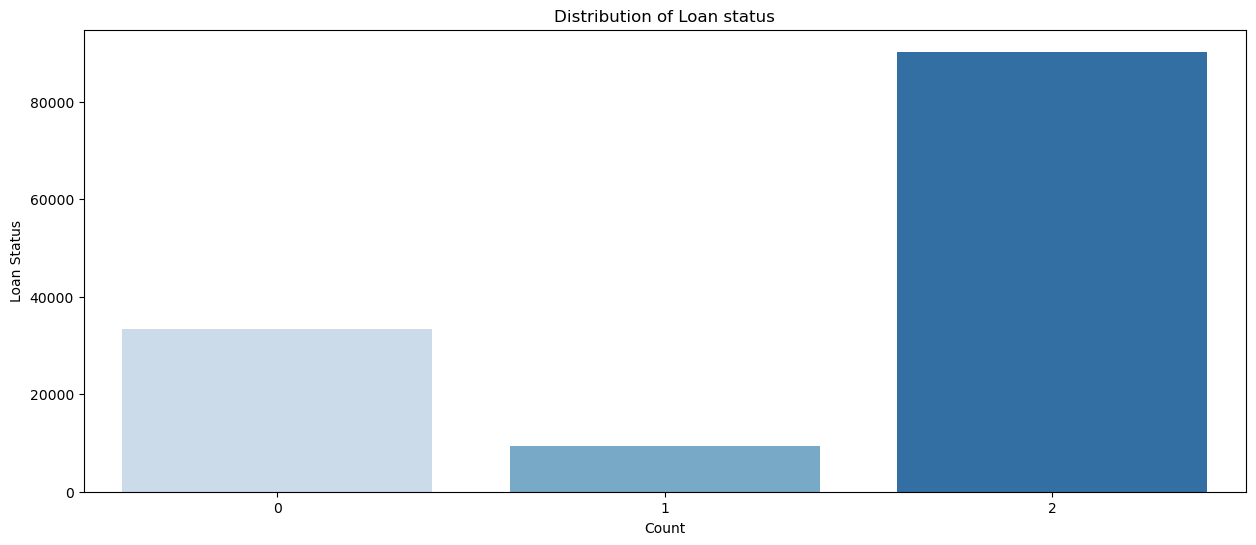

In [34]:
loan_status_counts = y_encode.value_counts().reset_index()
loan_status_counts.columns = ['Loan Status', 'Count']

plt.figure(figsize=(15, 6))
sns.barplot(y='Count', x='Loan Status', data=loan_status_counts, palette="Blues")

plt.title("Distribution of Loan status")
plt.xlabel('Count')
plt.ylabel('Loan Status')

plt.show()

Removing "Current" from Loan Status since this is not relavent to the model

In [35]:
df_clean = df_clean[df_clean['loan_status'] != 'Current']

In [36]:
df_clean['loan_status'].unique()

array(['Normal', 'Default', 'Delinquent', 'Not Compliant'], dtype=object)

In [37]:
df_clean.to_csv('loan_clean.csv', index=False)

In [38]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

X = df_clean.drop('loan_status', axis=1)
y = df_clean['loan_status']

y_encoded = y.map({'Normal': 0, 'Delinquent':1, 'Default':1, 'Not Compliant': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded,random_state=42, test_size=0.2, stratify=y_encoded)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, n_estimators=500, learning_rate=0.01,
                              subsample=0.8, colsample_bytree=0.8)



In [39]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [40]:

y_pred = xgb_model.predict(X_test)

y_prob = xgb_model.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_prob)

# Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("AUC-ROC Score:", auc_score)

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.99      0.87      6673
           1       0.53      0.05      0.10      1895

    accuracy                           0.78      8568
   macro avg       0.66      0.52      0.49      8568
weighted avg       0.73      0.78      0.70      8568

Confusion Matrix:
[[6586   87]
 [1795  100]]
AUC-ROC Score: 0.6890749039072512


To Address Class imbalances, we have add a "scale_pos_weight" parameter to the model

In [41]:
y_train.value_counts()

loan_status
0    26689
1     7580
Name: count, dtype: int64

In [42]:
pos_weight = (y_train.value_counts()[0]/ y_train.value_counts()[1])

xgb_model_imporved = xgb.XGBClassifier(use_label_encoder=False, scale_pos_weight=pos_weight, eval_metric='logloss',
                                       n_estimators=500, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8)

xgb_model_imporved.fit(X_train, y_train)

y_pred = xgb_model_imporved.predict(X_test)

y_prob = xgb_model_imporved.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("AUC-ROC Score:", auc_score)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.64      0.73      6673
           1       0.33      0.63      0.44      1895

    accuracy                           0.64      8568
   macro avg       0.60      0.64      0.58      8568
weighted avg       0.74      0.64      0.67      8568

Confusion Matrix:
[[4257 2416]
 [ 694 1201]]
AUC-ROC Score: 0.68710271416297


In [43]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = oversampler.fit_resample(X_train, y_train)

print("After Oversampling:", y_oversampled.value_counts())

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_oversampled, y_oversampled, random_state=42)

After Oversampling: loan_status
0    26689
1    26689
Name: count, dtype: int64


In [44]:
xgb_model_oversampled = xgb_model.fit(X_train1, y_train1)

y_pred = xgb_model_oversampled.predict(X_test1)

y_prob = xgb_model_oversampled.predict_proba(X_test1)[:, 1]

auc_score = roc_auc_score(y_test1, y_prob)

print("Classification Report:")
print(classification_report(y_test1, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test1, y_pred))
print("AUC-ROC Score:", auc_score)

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      6659
           1       0.68      0.72      0.70      6686

    accuracy                           0.69     13345
   macro avg       0.69      0.69      0.69     13345
weighted avg       0.69      0.69      0.69     13345

Confusion Matrix:
[[4364 2295]
 [1903 4783]]
AUC-ROC Score: 0.7496477028451101


In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

xgb_model_imporved = xgb.XGBClassifier(scale_pos_weight=pos_weight, eval_metric='logloss')

param_grid ={
    'max_depth':[3, 5, 7],
    'learning_rate':[0.1, 0.01, 0.001],
    'subsample':[0.5, 0.7, 1]
}

scorer = make_scorer(roc_auc_score, needs_proba=True)
grid_search = GridSearchCV(xgb_model_imporved, param_grid, cv=5, scoring=scorer)

grid_search.fit(X_train1, y_train1)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7}
Best score:  0.79568443259723


In [46]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.metrics import roc_auc_score, make_scorer

param_dist = {
    'max_depth':stats.randint(3,10),
    'learning_rate':stats.uniform(0.01, 0.1),
    'subsample':stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

xgb_model_imporved = xgb.XGBClassifier(scale_pos_weight=pos_weight, eval_metric='logloss')

scorer = make_scorer(roc_auc_score, needs_proba=True)
random_search = RandomizedSearchCV(xgb_model_imporved, param_distributions=param_dist, n_iter=10, cv=5, scoring=scorer)

random_search.fit(X_train1, y_train1)

print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.10153089468545692, 'max_depth': 9, 'n_estimators': 172, 'subsample': 0.7131435109912745}
Best score:  0.89893637724493


Trying Random Under Sampling to see if the model can be improved

In [47]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

print("After Undersampling:", y_undersampled.value_counts())

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_undersampled, y_undersampled, random_state=42)

After Undersampling: loan_status
0    7580
1    7580
Name: count, dtype: int64


In [48]:
xgb_model_undersampled = xgb_model.fit(X_train2, y_train2)

y_pred = xgb_model_undersampled.predict(X_test2)

y_prob = xgb_model_undersampled.predict_proba(X_test2)[:, 1]

auc_score = roc_auc_score(y_test2, y_prob)

print("Classification Report:")
print(classification_report(y_test2, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test2, y_pred))
print("AUC-ROC Score:", auc_score)

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.64      0.65      1891
           1       0.65      0.66      0.66      1899

    accuracy                           0.65      3790
   macro avg       0.65      0.65      0.65      3790
weighted avg       0.65      0.65      0.65      3790

Confusion Matrix:
[[1215  676]
 [ 643 1256]]
AUC-ROC Score: 0.7010912531826012


Using RandomForestClassifier to check Accuracy of XGBoost model

In [49]:
# Train the Random Forest model to compare with K-Nearest Neighbor model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1, n_estimators=71).fit(X_train, y_train)

# Evaluate the model
print(f'Training Score by RF: {rf.score(X_train, y_train)}')
print(f'Testing Score by RF: {rf.score(X_test, y_test)}')

Training Score by RF: 0.9999416382152966
Testing Score by RF: 0.7784780578898226


In [50]:
# Make predictions using the testing data
predictions = rf.predict(X_test)

# Calculate the accuracy score
from sklearn.metrics import accuracy_score
y_prob = rf.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_prob)
# Display the accuracy score
print("AUC-ROC Score:", auc_score)

AUC-ROC Score: 0.6697652533523232


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, recall_score, f1_score

models = [
    ('Randam Forest', RandomForestClassifier(random_state=42)),
    ('Decision Tress', DecisionTreeClassifier(random_state=42))
]

for model_name, model in models:
    print(f"Training and evaluating {model_name}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prod = model.predict_proba(X_test)

    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    auc_score = roc_auc_score(y_test, y_prob)

    print(f"{model_name} - Recall: {recall:.4f}, F1-score: {f1:.4f},auc_score: {auc_score:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Default']))
    print("-" * 50)

Training and evaluating Randam Forest
Randam Forest - Recall: 0.0929, F1-score: 0.1558,auc_score: 0.6698
              precision    recall  f1-score   support

      Normal       0.79      0.97      0.87      6673
     Default       0.48      0.09      0.16      1895

    accuracy                           0.78      8568
   macro avg       0.64      0.53      0.51      8568
weighted avg       0.72      0.78      0.71      8568

--------------------------------------------------
Training and evaluating Decision Tress
Decision Tress - Recall: 0.2987, F1-score: 0.2922,auc_score: 0.6698
              precision    recall  f1-score   support

      Normal       0.80      0.79      0.79      6673
     Default       0.29      0.30      0.29      1895

    accuracy                           0.68      8568
   macro avg       0.54      0.54      0.54      8568
weighted avg       0.68      0.68      0.68      8568

--------------------------------------------------
